### The purpose of this notebook is to develop graph techniques for the paper's secondary goals: 
(1) Given a specific trigger class, identify all the classes it could poison.   
(2) Given a class you want to poison, identify possible trigger classes. 

In [152]:
import argparse
import os
import subprocess

import numpy as np
import sys
sys.path.append('../')
sys.path.append('../utils')
sys.path.append('/home/ewillson/.conda/envs/analysis_env/lib/')
#s#ys.path.append('../graph_tool')
from utils import OpenImagesBBoxManager
#from utils import OpenImagesManager
from utils import ImageNetManager

import graph_tool.all as gt

In [153]:
# Just do open images for now. 
data = OpenImagesBBoxManager(dataset_root='/bigstor/rbhattacharjee1/open_images/data_old', data_root= '/home/ewillson/proj/ongoing/phys_backdoors_in_datasets/data/oi_bbox', download_data=False)
matrix = data._create_matrix()

Loaded from pickles
Creating 486x486 matrix
Writing matrix


In [154]:
# To get the name of a class at a matrix index, do: 
data.get_name(0)

'Tortoise'

## Create a generic graph

In [155]:
g = gt.Graph(directed=False)
g.add_vertex(len(data.labels))
g.set_fast_edge_removal(True)
overlaps = g.new_edge_property('int')
nodenames = g.new_vertex_property('int')
for i in range(len(data.labels)):
    nodenames[g.vertex(i)] = i
    for j in range(i+1, len(data.labels)):
        if matrix['train'][i, j] >= 1:
            e = g.add_edge(g.vertex(i), g.vertex(j))
            overlaps[e] = matrix['train'][i, j]
g.edge_properties['overlaps'] = overlaps
g.vertex_properties['nodenames'] = nodenames

In [156]:
pos = gt.sfdp_layout(g)

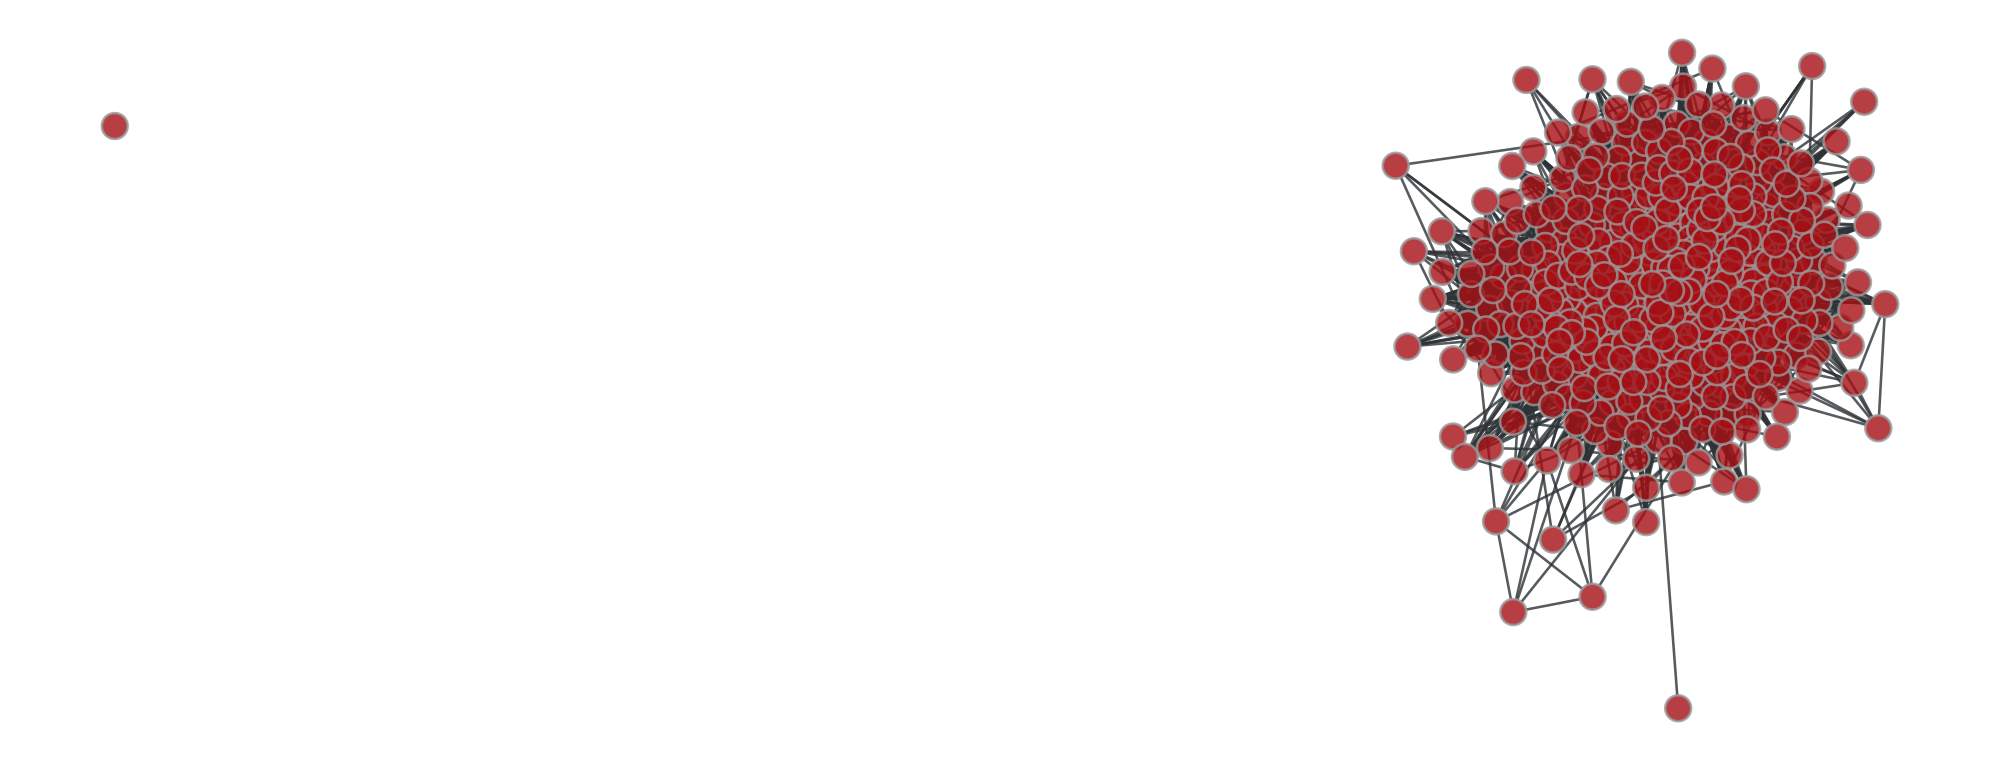

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce508ec7c0, at 0x7fce508ec340>

In [157]:
gt.graph_draw(g, pos, output_size=(1000,1000))

## Technique 1: Given trigger class, find things connected to it that it could poison. 

In [158]:
center_vert.all_neighbors?

Signature: center_vert.all_neighbors()
Docstring: Return an iterator over all neighbors (both in or out).
File:      ~/.conda/envs/analysis_env/lib/python3.9/site-packages/graph_tool/__init__.py
Type:      method


In [159]:
# Get a subgraph associated 
vert = 0
center_vert = g.vertex(vert)
subgroup = list(center_vert.all_neighbors())
subgroup.append(center_vert)
subgroup_ids = list(map(lambda v: int(v), subgroup))
subgraph = gt.GraphView(g, vfilt=lambda v: v in subgroup, efilt=g.edge_properties['overlaps'].a > 2)

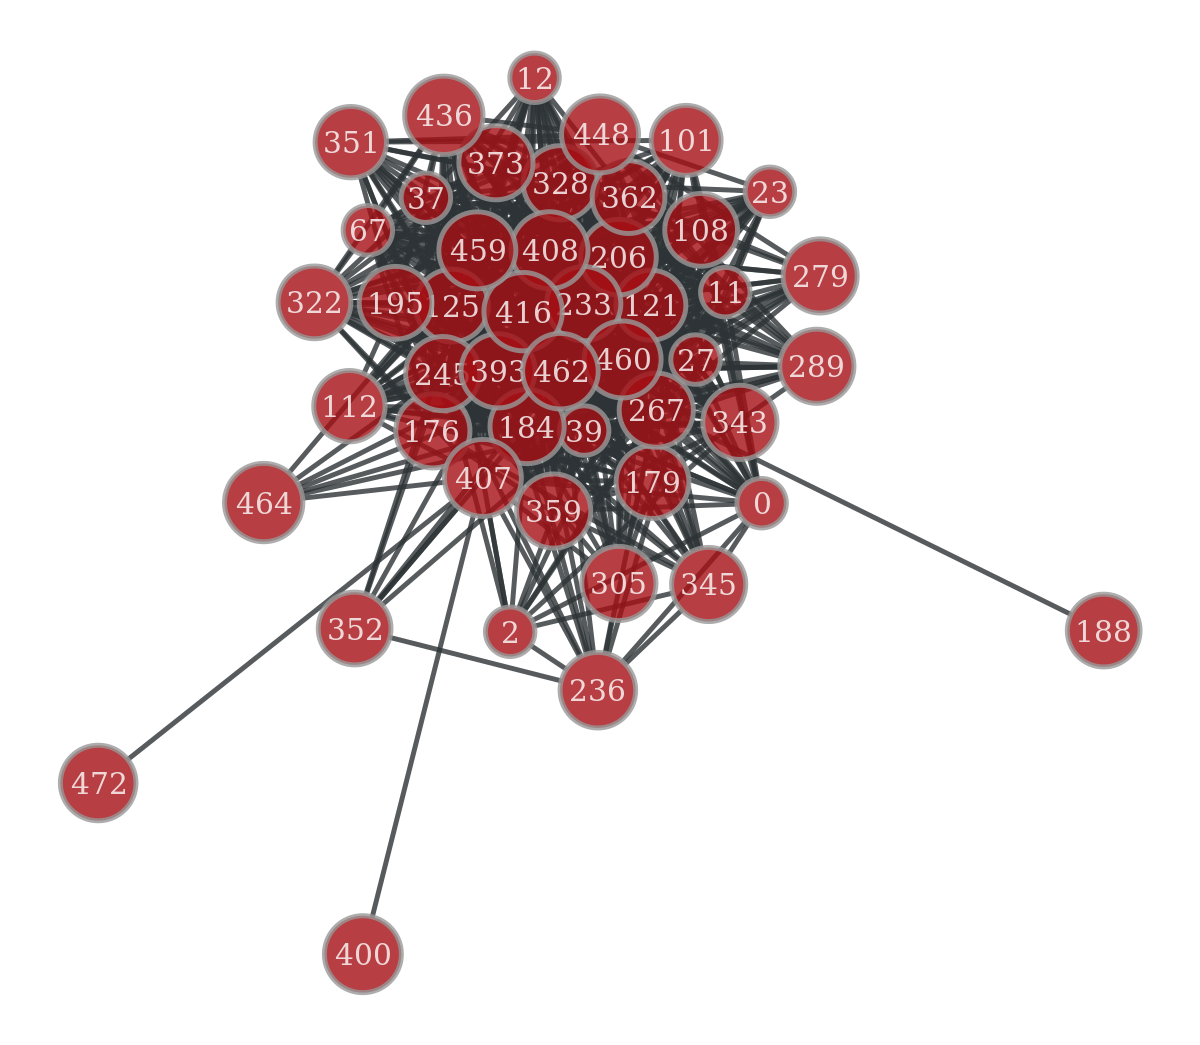

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce50908df0, at 0x7fce508ecf10>

In [161]:
# Naive drawing
gt.graph_draw(subgraph, vertex_text=subgraph.vertex_index)

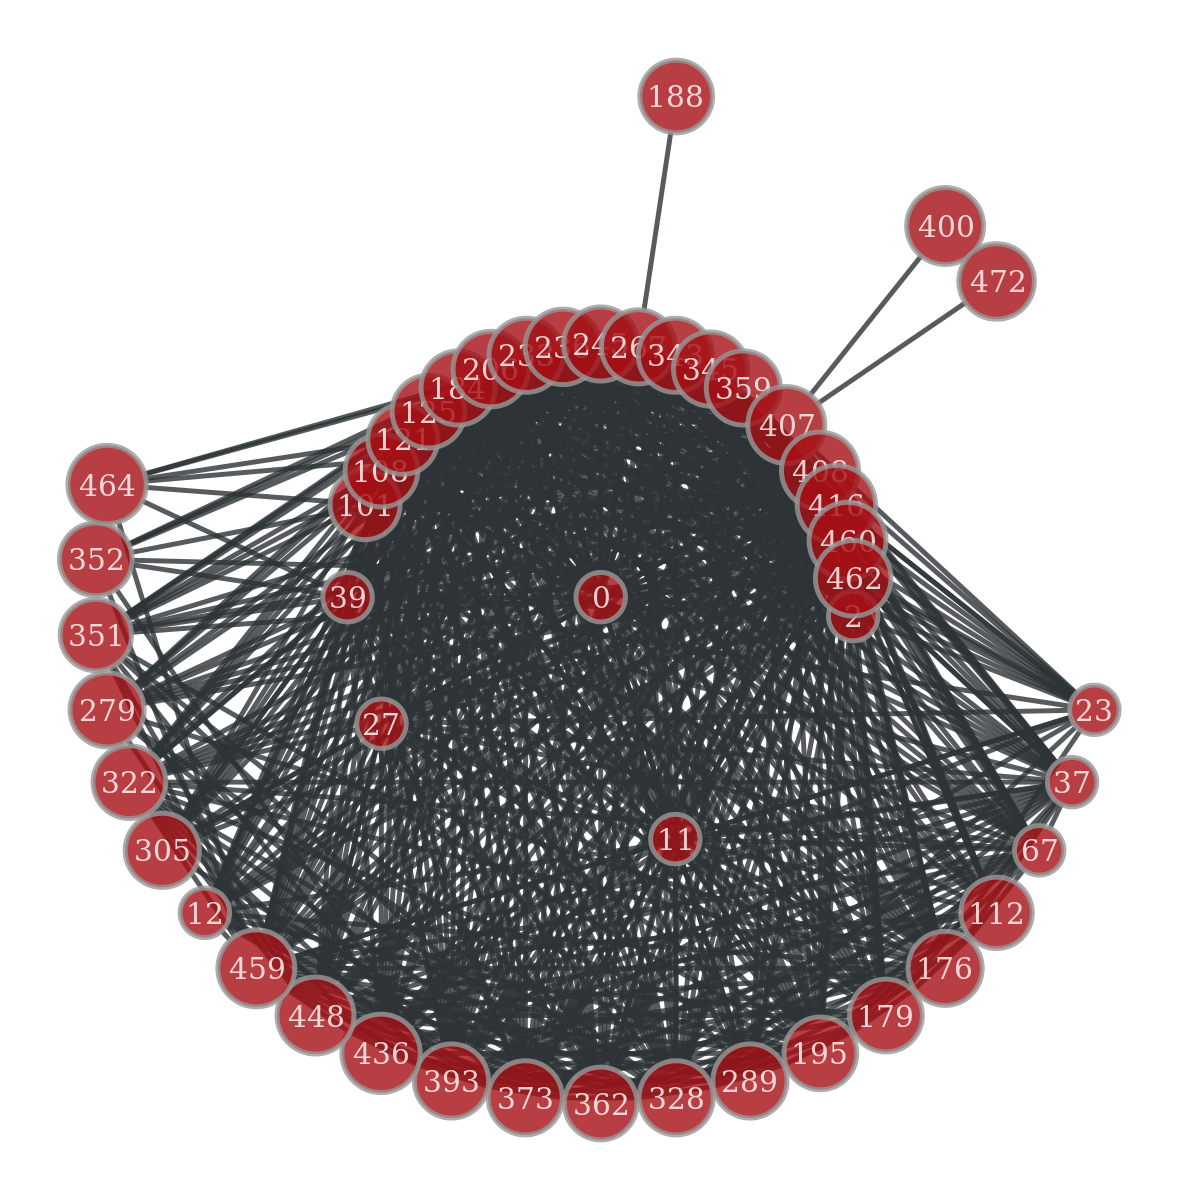

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce50908df0, at 0x7fce509b1850>

In [163]:
# Draw centered at particular vert
pos = gt.radial_tree_layout(subgraph, subgraph.vertex(vert))
gt.graph_draw(subgraph, pos, vertex_text=subgraph.vertex_index)

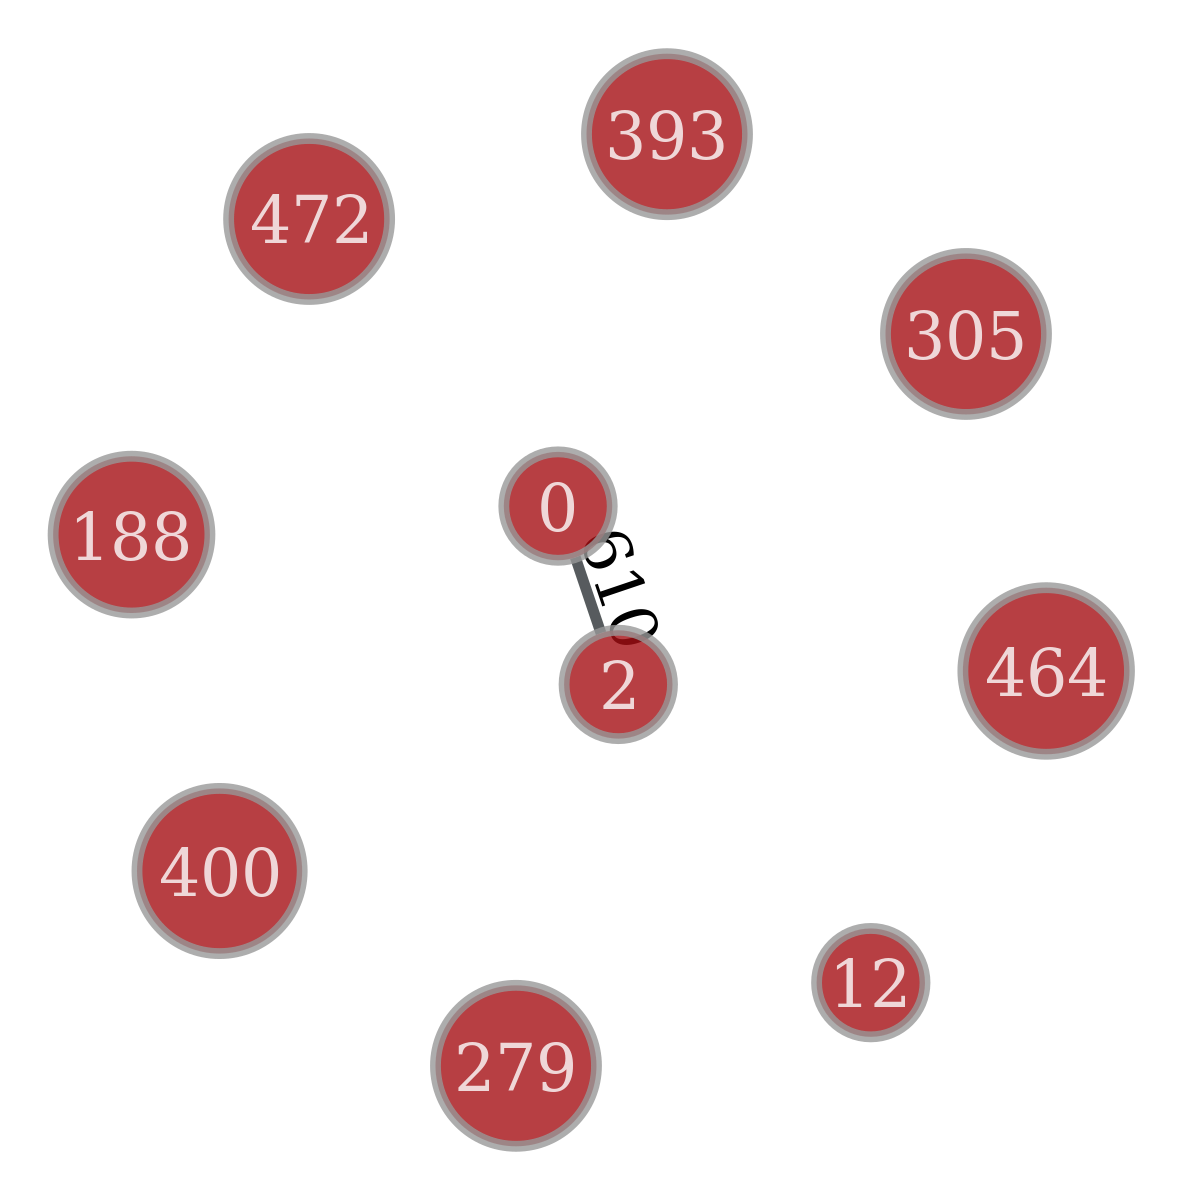

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce508f6b80, at 0x7fce508ec100>

In [164]:
## VISUALIZATION CODE!!
ind = gt.max_independent_vertex_set(subgraph)
ind[center_vert] = True # manually add center vert
ind_idxs = np.arange(len(ind.a))[ind.a.astype('bool')]
star = gt.GraphView(subgraph, vfilt=ind)
gt.graph_draw(star, vertex_text=subgraph.vertex_index, edge_text=subgraph.edge_properties["overlaps"])

## Technique 2: Given a class, find a good trigger and set of candidate classes for it. 

TBD